In [51]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/summer2winter-yosemite/metadata.csv
/kaggle/input/summer2winter-yosemite/testB/2012-04-17 12_43_11.jpg
/kaggle/input/summer2winter-yosemite/testB/2013-12-24 17_54_21.jpg
/kaggle/input/summer2winter-yosemite/testB/2015-12-31 17_23_30.jpg
/kaggle/input/summer2winter-yosemite/testB/2012-02-15 12_22_01.jpg
/kaggle/input/summer2winter-yosemite/testB/2017-03-03 01_07_50.jpg
/kaggle/input/summer2winter-yosemite/testB/2015-12-16 08_32_11.jpg
/kaggle/input/summer2winter-yosemite/testB/2016-12-30 11_28_51.jpg
/kaggle/input/summer2winter-yosemite/testB/2016-12-21 06_56_11.jpg
/kaggle/input/summer2winter-yosemite/testB/2012-03-23 01_13_40.jpg
/kaggle/input/summer2winter-yosemite/testB/2013-08-01 00_20_40.jpg
/kaggle/input/summer2winter-yosemite/testB/2012-01-07 11_08_11.jpg
/kaggle/input/summer2winter-yosemite/testB/2012-06-15 16_43_00.jpg
/kaggle/input/summer2winter-yosemite/testB/2011-12-14 12_29_11.jpg
/kaggle/input/summer2winter-yosemite/testB/2008-06-23 19_37_41.jpg
/kaggle/inpu

**IMPORTING NECESSARY PACKAGES**

In [52]:
import os
import numpy as np
import math
import itertools
import scipy
import sys
import time
import datetime

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
import torch.autograd as autograd
from torchvision.utils import make_grid

import torch.nn as nn
import torch.nn.functional as F
import torch

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from IPython.display import clear_output

import glob
import random
from torch.utils.data import Dataset
from PIL import Image


**LOADING DATASET**

In [53]:
train_A_paths = glob.glob('../input/summer2winter-yosemite/trainA/*.jpg')
train_B_paths = glob.glob('../input/summer2winter-yosemite/trainB/*.jpg')
print('Len of trainA：',len(train_A_paths))
print('Len of testA：',len(train_B_paths))

test_A_paths = glob.glob('../input/summer2winter-yosemite/testA/*.jpg')
test_B_paths = glob.glob('../input/summer2winter-yosemite/testB/*.jpg')
print('Len of test：',len(test_A_paths))
print('Len of testB：',len(test_B_paths))


Len of trainA： 1231
Len of testA： 962
Len of test： 309
Len of testB： 238


**SETTING THE HYPERPARAMETERS**

In [54]:
class Hyperparameters(object):
  def __init__(self, **kwargs):
    self.__dict__.update(kwargs)

hp = Hyperparameters(
    epoch=0,
    n_epochs=200,    
    dataset_train_mode="train",
    dataset_test_mode="test", 
    batch_size=4,        
    lr=.0002,
    decay_start_epoch=100,
    b1=.5,
    b2=0.999,
    n_cpu=8,
    img_size=128,
    channels=3,
    n_critic=5,
    sample_interval=100,
    num_residual_blocks=19,
    lambda_cyc=10.0,
    lambda_id=5.0)
root_path = '../input/summer2winter-yosemite'

In [55]:


def convert_to_rgb(image):
    rgb_image = Image.new("RGB", image.size)
    rgb_image.paste(image)
    return rgb_image


class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, unaligned=False, mode="train"):
        self.transform = transforms.Compose(transforms_)
        self.unaligned = unaligned        

        self.files_A = sorted(glob.glob(os.path.join(root, "%sA" % mode) + "/*.*"))
        self.files_B = sorted(glob.glob(os.path.join(root, "%sB" % mode) + "/*.*"))
       
    def __getitem__(self, index):
        image_A = Image.open(self.files_A[index % len(self.files_A)])

        if self.unaligned:
            image_B = Image.open(self.files_B[random.randint(0, len(self.files_B) - 1)])
        else:
            image_B = Image.open(self.files_B[index % len(self.files_B)])

        # Convert grayscale images to rgb
        if image_A.mode != "RGB":
            image_A = convert_to_rgb(image_A)
        if image_B.mode != "RGB":
            image_B = convert_to_rgb(image_B)

        item_A = self.transform(image_A)
        item_B = self.transform(image_B)
        

        return {"A": item_A, "B": item_B}

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))



**METHOD FOR IMAGE VISUALIZATION**

In [56]:
def show_img(img,size=10):
  img = img / 2 + 0.5     
  npimg = img.numpy()
  plt.figure(figsize=(size, size))
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()
'''  The reason for doing "np.transpose(npimg, (1, 2, 0))"

PyTorch modules processing image data expect tensors in the format C × H × W.
Whereas PILLow and Matplotlib expect image arrays in the format H × W × C
so to use them with matplotlib you need to reshape it
to put the channels as the last dimension:

I could have used permute() method as well like below 
plt.imshow(pytorch_tensor_image.permute(1, 2, 0))
'''

def to_img(x):    
    x = x.view(x.size(0)*2, hp.channels, hp.img_size, hp.img_size)
    return x

import matplotlib.image as mpimg

def plot_output(path, x, y):
    img = mpimg.imread(path)
    plt.figure(figsize=(x,y))
    plt.imshow(img)  
    plt.show()

**GET TRAIN AND VALIDATION DATALOADER**

In [57]:
transforms_ = [
    transforms.Resize((hp.img_size, hp.img_size), Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]

train_dataloader = DataLoader(
    ImageDataset(root_path, mode=hp.dataset_train_mode, transforms_=transforms_),
    batch_size=hp.batch_size,
    shuffle=True,
    num_workers=1,
)
val_dataloader = DataLoader(
    ImageDataset(root_path, mode=hp.dataset_test_mode, transforms_=transforms_),
    batch_size=16,
    shuffle=True,
    num_workers=1,
)

**VISUALIZE SOME SAMPLE IMAGES**

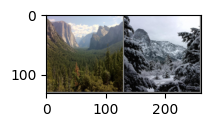

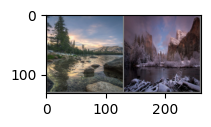

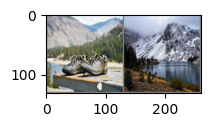

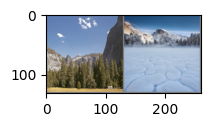

In [58]:
pic_size = 2 

dataiter = iter(train_dataloader)
images = next(dataiter)

for i in range(len(images["A"])):
  show_img(make_grid([images["A"][i],images["B"][i]]), size=pic_size)

**REPLAY BUFFER**

In [59]:
class ReplayBuffer:
    # We keep an image buffer that stores
    # the 50 previously created images.
    def __init__(self, max_size=50):
        assert max_size > 0, "Empty buffer."
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                # Returns newly added image with a probability of 0.5.
                if random.uniform(0, 1) > 0.5:
                    i = random.randint(0, self.max_size - 1)
                    to_return.append(self.data[i].clone())
                    self.data[
                        i
                    ] = element  # replaces the older image with the newly generated image.
                else:
                    # Otherwise, it sends an older generated image and
                    to_return.append(element)
        return Variable(torch.cat(to_return))

**LEARNING RATE SCHEDULING USING lr_lambda**

In [60]:
class LambdaLR:
    def __init__(self, n_epochs, offset, decay_start_epoch):
        assert (n_epochs - decay_start_epoch) > 0, "Decay must start before the training session ends!"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch

    def step(self, epoch):
        # Below line checks whether the current epoch has exceeded the decay epoch(which is 100)
        # e.g. if current epoch is 80 then max (0, 80 - 100) will be 0. 
        # i.e. then entire numerator will be 0 - so 1 - 0 is 1
        # i.e. the original LR remains as it is.
        return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch) / (self.n_epochs - self.decay_start_epoch)

**INITIALIZE CONVOLUTIONAL LAYER WEIGHTS OF N(0,0.02**

In [61]:
def initialize_conv_weights_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
        if hasattr(m, "bias") and m.bias is not None:
            torch.nn.init.constant_(m.bias.data, 0.0)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

**GENERATOR AND DISCRIMINATOR**
**1.RESIDUAL-BLOCK**

In [62]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channel):
        super(ResidualBlock, self).__init__()

        self.block = nn.Sequential(
            nn.ReflectionPad2d(1), 
            nn.Conv2d(in_channel, in_channel, 3), 
            nn.InstanceNorm2d(in_channel),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channel, in_channel, 3),
            nn.InstanceNorm2d(in_channel),
        )

    def forward(self, x):
        return x + self.block(x)

**GENERATOR**

In [63]:
class GeneratorResNet(nn.Module):
    def __init__(self, input_shape, num_residual_blocks):
        super(GeneratorResNet, self).__init__()

        channels = input_shape[0]

        # Initial convolution block
        out_channels = 64
        # I define a variable 'model' which I will continue to update
        # throughout the 3 blocks of Residual -> Downsampling -> Upsampling
        # First c7s1-64
        model = [
            nn.ReflectionPad2d(channels),
            nn.Conv2d(channels, out_channels, 7),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True),
        ]
        in_channels = out_channels

        # Downsampling
        # d128 => d256
        for _ in range(2):
            out_channels *= 2
            model += [
                nn.Conv2d(in_channels, out_channels, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True),
            ]
            in_channels = out_channels

       
        for _ in range(num_residual_blocks):
            model += [ResidualBlock(out_channels)]

        # Upsampling
        # u128 => u64
        for _ in range(2):
            out_channels //= 2
            model += [
                nn.Upsample(scale_factor=2),
                nn.Conv2d(in_channels, out_channels, 3, stride=1, padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True),
            ]
            in_channels = out_channels

        # Output layer
        model += [
            nn.ReflectionPad2d(channels),
            nn.Conv2d(out_channels, channels, 7),
            nn.Tanh(),
        ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

**DISCRIMINATOR**

In [64]:
class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()

        channels, height, width = input_shape

        # Calculate output shape of image discriminator (PatchGAN)
        self.output_shape = (1, height // 2 ** 4, width // 2 ** 4)

        def discriminator_block(in_channels, out_channels, normalize=True):
            layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        # C64 -> C128 -> C256 -> C512
        self.model = nn.Sequential(
            *discriminator_block(channels, out_channels=64, normalize=False),
            *discriminator_block(64, out_channels=128),
            *discriminator_block(128, out_channels=256),
            *discriminator_block(256, out_channels=512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, padding=1)
        )
        # With nn.ZeroPad2d((1, 0, 1, 0)) I am Zero padding
        # on top and left to keep the output height and width same with the 4×4 kernel

    def forward(self, img):
        return self.model(img)


**PATCHGAN IMPLEMENTATION**

In [65]:
def get_input_size(output_size, filter_size, stride):
    return (output_size - 1) * stride + filter_size

# Now invoke above method to calculate the size of various layers in 
# Discriminator Network

last_layer = get_input_size(output_size=1, filter_size=4, stride=1)

fourth_layer_input_size = get_input_size(output_size=last_layer, filter_size=4, stride=1)
print("fourth_layer ", fourth_layer_input_size)

"""Receptive field: 7"""
third_layer_input_size = get_input_size(output_size=fourth_layer_input_size, filter_size=4, stride=2)
print("third_layer_input_size ", third_layer_input_size)

"""Receptive field: 16"""
second_layer_input_size = get_input_size(output_size=third_layer_input_size, filter_size=4, stride=2)
print('second_layer_input_size ', second_layer_input_size)

"""Receptive field: 34"""
first_layer_input_size = get_input_size(output_size=second_layer_input_size, filter_size=4, stride=2)
print('first_layer_input_size ', first_layer_input_size)

"""Receptive field: 70"""

fourth_layer  7
third_layer_input_size  16
second_layer_input_size  34
first_layer_input_size  70


'Receptive field: 70'

**SETUP, LOSS, INITIALIZE MODELS, BUFFERS**

In [66]:

cuda = True if torch.cuda.is_available() else False
print("Using CUDA" if cuda else "Not using CUDA")

# Loss functions
# Creating criterion object that will measure the error between the prediction and the target.
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

input_shape = (hp.channels, hp.img_size, hp.img_size)

# Initialize generator and discriminator
Gen_AB = GeneratorResNet(input_shape, hp.num_residual_blocks)
Gen_BA = GeneratorResNet(input_shape, hp.num_residual_blocks)
Disc_A = Discriminator(input_shape)
Disc_B = Discriminator(input_shape)

if cuda:
    Gen_AB = Gen_AB.cuda()
    Gen_BA = Gen_BA.cuda()
    Disc_A = Disc_A.cuda()
    Disc_B = Disc_B.cuda()
    criterion_GAN.cuda()
    criterion_cycle.cuda()
    criterion_identity.cuda()

# Initialize weights
Gen_AB.apply(initialize_conv_weights_normal)
Gen_BA.apply(initialize_conv_weights_normal)
Disc_A.apply(initialize_conv_weights_normal)
Disc_B.apply(initialize_conv_weights_normal)

# Buffers of previously generated samples
fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()


Using CUDA


In [67]:
import os
from torchvision.utils import make_grid, save_image
from torch.autograd import Variable

def save_img_samples(batches_done):
    """Saves a generated sample from the test set"""
    print('batches_done', batches_done)

    # Get a batch of validation data
    imgs = next(iter(val_dataloader))
    Gen_AB.eval()
    Gen_BA.eval()

    real_A = Variable(imgs["A"].type(Tensor))
    real_B = Variable(imgs["B"].type(Tensor))

    # Generate fake images
    fake_B = Gen_AB(real_A)
    fake_A = Gen_BA(real_B)

    # Arrange images for visualization
    real_A = make_grid(real_A, nrow=16, normalize=True)
    fake_B = make_grid(fake_B, nrow=16, normalize=True)
    real_B = make_grid(real_B, nrow=16, normalize=True)
    fake_A = make_grid(fake_A, nrow=16, normalize=True)

    image_grid = torch.cat((real_A, fake_B, real_B, fake_A), 1)

    # Choose a writable directory
    save_dir = "./outputs"
    os.makedirs(save_dir, exist_ok=True)

    path = os.path.join(save_dir, f"{batches_done}.png")
    save_image(image_grid, path, normalize=False)

    return path


**OPTIMIZERS**

In [68]:
optimizer_G = torch.optim.Adam(
    itertools.chain(Gen_AB.parameters(), Gen_BA.parameters()), lr=hp.lr, betas=(hp.b1, hp.b2)
)
optimizer_Disc_A = torch.optim.Adam(Disc_A.parameters(), lr=hp.lr, betas=(hp.b1, hp.b2))

optimizer_Disc_B = torch.optim.Adam(Disc_B.parameters(), lr=hp.lr, betas=(hp.b1, hp.b2))

# Learning rate update schedulers
lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(
    optimizer_G, lr_lambda=LambdaLR(hp.n_epochs, hp.epoch, hp.decay_start_epoch).step
)

lr_scheduler_Disc_A = torch.optim.lr_scheduler.LambdaLR(
    optimizer_Disc_A, lr_lambda=LambdaLR(hp.n_epochs, hp.epoch, hp.decay_start_epoch).step
)

lr_scheduler_Disc_B = torch.optim.lr_scheduler.LambdaLR(
    optimizer_Disc_B, lr_lambda=LambdaLR(hp.n_epochs, hp.epoch, hp.decay_start_epoch).step
)
Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

**TRAINING**

In [69]:
def train(
    Gen_BA,
    Gen_AB,
    Disc_A,
    Disc_B,
    train_dataloader,
    n_epochs,
    criterion_identity,
    criterion_cycle,
    lambda_cyc,
    criterion_GAN,
    optimizer_G,
    fake_A_buffer,
    fake_B_buffer,
    clear_output,
    optimizer_Disc_A,
    optimizer_Disc_B,
    Tensor,
    sample_interval,
    lambda_id,
):
    # TRAINING
    prev_time = time.time()
    for epoch in range(hp.epoch, n_epochs):
        for i, batch in enumerate(train_dataloader):

            # Set model input
            real_A = Variable(batch["A"].type(Tensor))
            real_B = Variable(batch["B"].type(Tensor))

            # Adversarial ground truths
            valid = Variable(
                Tensor(np.ones((real_A.size(0), *Disc_A.output_shape))),
                requires_grad=False,
            )
            fake = Variable(
                Tensor(np.zeros((real_A.size(0), *Disc_A.output_shape))),
                requires_grad=False,
            )

            #########################
            #  Train Generators
            #########################

            Gen_AB.train() # Gen_AB(real_A) will take real_A and produce fake_B
            Gen_BA.train() # Gen_BA(real_B) will take real_B and produce fake_A

            """
            PyTorch stores gradients in a mutable data structure. So we need to set it to a clean state before we use it.
            Otherwise, it will have old information from a previous iteration.
            """
            optimizer_G.zero_grad()

            # Identity loss
            # First pass real_A images to the Genearator, that will generate A-domains images
            loss_id_A = criterion_identity(Gen_BA(real_A), real_A)
            ''' So Gen_BA() was actually supposed to take real_B and and produce images for domain A
            but for calculating Identity loss I will pass to Gen_BA() the target domain images itself
            so ideally in this case, Gen_BA() should work as an identity function
            i.e. its output should be the input itself. And if there's a difference between 
            input and output, then that should be my Identity Loss.
            
            '''
            

            # Then pass real_B images to the Genearator, that will generate B-domains images
            loss_id_B = criterion_identity(Gen_AB(real_B), real_B)

            loss_identity = (loss_id_A + loss_id_B) / 2

            # GAN losses for GAN_AB
            fake_B = Gen_AB(real_A)
            loss_GAN_AB = criterion_GAN(Disc_B(fake_B), valid)

            # GAN losses for GAN_BA
            fake_A = Gen_BA(real_B)
            loss_GAN_BA = criterion_GAN(Disc_A(fake_A), valid)

            loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2

            # Cycle Consistency losses
            reconstructed_A = Gen_BA(fake_B)

            """
            Forward Cycle Consistency Loss
            Forward cycle loss:  lambda * ||G_BtoA(G_AtoB(A)) - A|| (Equation 2 in the paper)
            Compute the cycle consistency loss by comparing the reconstructed reconstructed_A images with real real_A  images of domain A.
            Lambda for cycle loss is 10.0. Penalizing 10 times and forcing to learn the translation.
            """
            loss_cycle_A = criterion_cycle(reconstructed_A, real_A)

            reconstructed_B = Gen_AB(fake_A)

            """
            Backward Cycle Consistency Loss
            Backward cycle loss: lambda * ||G_AtoB(G_BtoA(B)) - B|| (Equation 2 of the Paper)
            Compute the cycle consistency loss by comparing the reconstructed reconstructed_B images with real real_B images of domain B.
            Lambda for cycle loss is 10.0. Penalizing 10 times and forcing to learn the translation.
            """
            loss_cycle_B = criterion_cycle(reconstructed_B, real_B)

            loss_cycle = (loss_cycle_A + loss_cycle_B) / 2

            """
            Finally, Total Generators Loss and Back propagation
            Add up all the Generators loss and cyclic loss (Equation 3 of paper. Also Equation I the code representation of the equation) and perform backpropagation with optimization.
            """
            loss_G = loss_GAN + lambda_cyc * loss_cycle + lambda_id * loss_identity

            loss_G.backward()

            """
            Now we just need to update all the parameters!
            Θ_{k+1} = Θ_k − η * ∇_Θ ℓ(y_hat, y)
            """
            optimizer_G.step()

            #########################
            #  Train Discriminator A
            #########################

            optimizer_Disc_A.zero_grad()

            # Real loss
            loss_real = criterion_GAN(Disc_A(real_A), valid)
            # Fake loss (on batch of previously generated samples)
            fake_A_ = fake_A_buffer.push_and_pop(fake_A)
            loss_fake = criterion_GAN(Disc_A(fake_A_.detach()), fake)

            """ Total loss for Disc_A
            And I divide by 2 because as per Paper - "we divide the objective by 2 while
            optimizing D, which slows down the rate at which D learns,
            relative to the rate of G."
            """
            loss_Disc_A = (loss_real + loss_fake) / 2

            """ do backpropagation i.e.
            ∇_Θ will get computed by this call below to backward() """
            loss_Disc_A.backward()

            """
            Now we just need to update all the parameters!
            Θ_{k+1} = Θ_k − η * ∇_Θ ℓ(y_hat, y)
            """
            optimizer_Disc_A.step()

            #########################
            #  Train Discriminator B
            #########################

            optimizer_Disc_B.zero_grad()

            # Real loss
            loss_real = criterion_GAN(Disc_B(real_B), valid)
            # Fake loss (on batch of previously generated samples)
            fake_B_ = fake_B_buffer.push_and_pop(fake_B)
            loss_fake = criterion_GAN(Disc_B(fake_B_.detach()), fake)

            """ Total loss for Disc_B
            And I divide by 2 because as per Paper - "we divide the objective by 2 while
            optimizing D, which slows down the rate at which D learns,
            relative to the rate of G."
            """
            loss_Disc_B = (loss_real + loss_fake) / 2

            """ do backpropagation i.e.
            ∇_Θ will get computed by this call below to backward() """
            loss_Disc_B.backward()

            """
            Now we just need to update all the parameters!
            Θ_{k+1} = Θ_k − η * ∇_Θ ℓ(y_hat, y)
            """
            optimizer_Disc_B.step()

            loss_D = (loss_Disc_A + loss_Disc_B) / 2

            ##################
            #  Log Progress
            ##################

            # Determine approximate time left
            batches_done = epoch * len(train_dataloader) + i
            batches_left = n_epochs * len(train_dataloader) - batches_done
            time_left = datetime.timedelta(
                seconds=batches_left * (time.time() - prev_time)
            )
            prev_time = time.time()

            print(
                "\r[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f, adv: %f, cycle: %f, identity: %f] ETA: %s"
                % (
                    epoch,
                    n_epochs,
                    i,
                    len(train_dataloader),
                    loss_D.item(),
                    loss_G.item(),
                    loss_GAN.item(),
                    loss_cycle.item(),
                    loss_identity.item(),
                    time_left,
                )
            )

            # If at sample interval save image
            if batches_done % sample_interval == 0:
                clear_output()
                plot_output(save_img_samples(batches_done), 30, 40)

batches_done 200


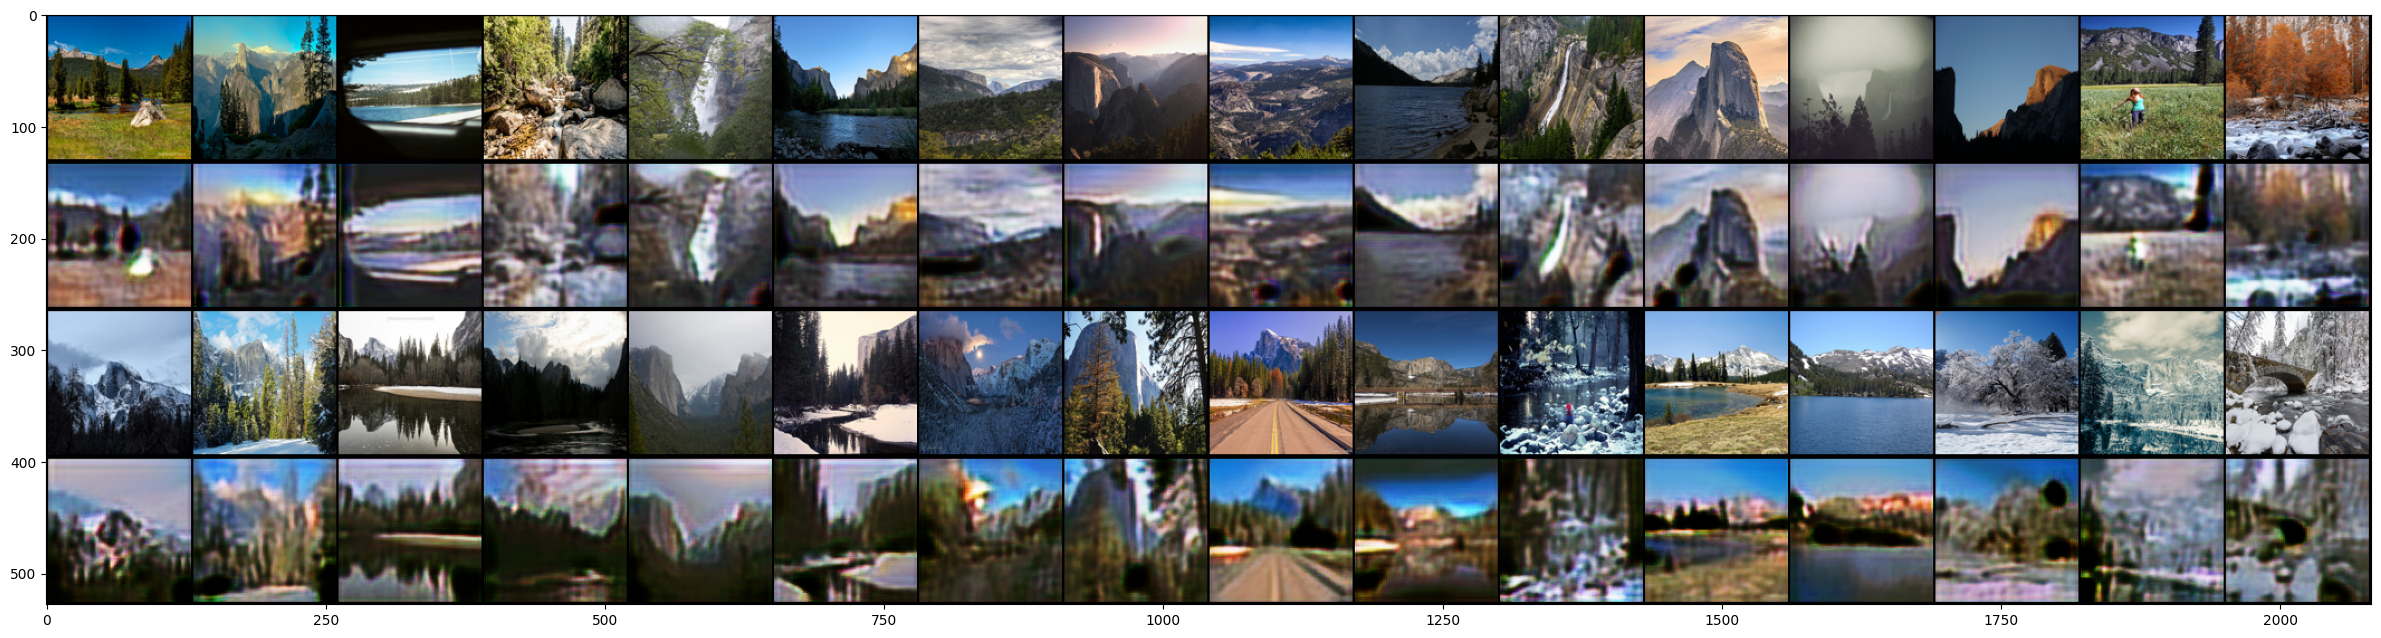

[Epoch 0/200] [Batch 201/308] [D loss: 0.231801] [G loss: 4.157424, adv: 0.436737, cycle: 0.251867, identity: 0.240404] ETA: 2 days, 1:08:51.465915
[Epoch 0/200] [Batch 202/308] [D loss: 0.282022] [G loss: 3.777966, adv: 0.374623, cycle: 0.229811, identity: 0.221047] ETA: 9:11:03.939853
[Epoch 0/200] [Batch 203/308] [D loss: 0.238280] [G loss: 3.949565, adv: 0.353237, cycle: 0.257077, identity: 0.205112] ETA: 9:10:20.438261
[Epoch 0/200] [Batch 204/308] [D loss: 0.259654] [G loss: 3.911625, adv: 0.331189, cycle: 0.253512, identity: 0.209064] ETA: 9:09:38.021276
[Epoch 0/200] [Batch 205/308] [D loss: 0.262143] [G loss: 3.872394, adv: 0.335371, cycle: 0.245130, identity: 0.217145] ETA: 9:10:50.101812
[Epoch 0/200] [Batch 206/308] [D loss: 0.259351] [G loss: 3.479747, adv: 0.399657, cycle: 0.209802, identity: 0.196413] ETA: 9:10:59.575522
[Epoch 0/200] [Batch 207/308] [D loss: 0.263210] [G loss: 4.485699, adv: 0.340562, cycle: 0.285122, identity: 0.258783] ETA: 9:10:42.394508
[Epoch 0/200

KeyboardInterrupt: 

In [70]:


train(
    Gen_BA = Gen_BA,
    Gen_AB = Gen_AB,
    Disc_A = Disc_A,
    Disc_B = Disc_B,
    train_dataloader = train_dataloader,
    n_epochs = hp.n_epochs,
    criterion_identity = criterion_identity,
    criterion_cycle = criterion_cycle,
    lambda_cyc = hp.lambda_cyc,
    criterion_GAN = criterion_GAN,
    optimizer_G = optimizer_G,
    fake_A_buffer = fake_A_buffer,
    fake_B_buffer = fake_B_buffer,
    clear_output = clear_output,
    optimizer_Disc_A = optimizer_Disc_A,
    optimizer_Disc_B = optimizer_Disc_B,
    Tensor = Tensor,
    sample_interval = hp.sample_interval,
    lambda_id = hp.lambda_id,
)

